In [0]:
import pickle
import io
import keras
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.optimizers import RMSprop
from keras.layers import Input, Dense, Dropout, Activation, Add, Concatenate
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPool2D, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
from keras.objectives import mean_squared_error
from sklearn.utils import class_weight
import keras.backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from keras.models import Sequential
from keras.losses import sparse_categorical_crossentropy
from keras.losses import categorical_crossentropy

Downloading dataset

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
dict = {0:'Airplane', 1:'Automobile', 2:'Bird', 3:'Cat', 4:'Deer', 5:'Dog', 6:'Frog', 7:'Horse', 8:'Ship', 9:'Truck'}

170500096/170498071 [==============================] - 13s 0us/step


Creating training and testing data under the following condition. 1. For deer,truck and bird, use only 50% of images available. ie, use only 3000 images for training and 3000 images for testing (only for these 3 classes). Hence, the size of training set will be 44000 and testing will be 16000. 
 

In [0]:
x_test_new = []
y_test_new = []
x_train_final = []
y_train_final = []
count = [0, 0, 0]
for i, j in zip(x_train, y_train):
    if (j==2):
        if(count[0]<2000):
            x_test_new.append(i)
            y_test_new.append(j)
            count[0]+=1
        else:
            x_train_final.append(i)
            y_train_final.append(j)
    elif (j==4):
        if(count[1]<2000):
            x_test_new.append(i)
            y_test_new.append(j)
            count[1]+=1
        else:
            x_train_final.append(i)
            y_train_final.append(j)
    elif (j==9):
        if(count[2]<2000):
            x_test_new.append(i)
            y_test_new.append(j)
            count[2]+=1
        else:
            x_train_final.append(i)
            y_train_final.append(j)
    else:
        x_train_final.append(i)
        y_train_final.append(j)
        
x_test_new = np.array(x_test_new)
y_test_new = np.array(y_test_new)
x_train_final = np.array(x_train_final)
y_train_final = np.array(y_train_final)
  
    

In [0]:
x_test_final = np.append(x_test_new, x_test, axis=0)
y_test_final = np.append(y_test_new, y_test, axis=0)

**Preprocessing**
1. The input format should be float32. 
2. Normalising data

In [6]:
np.max(x_test_final)

255

In [0]:
x_train_final = x_train_final.astype('float32')
x_test_final = x_test_final.astype('float32')
x_train_final = x_train_final / 255
x_test_final = x_test_final / 255

In [8]:
np.max(x_train_final), np.max(x_test_final)

(1.0, 1.0)

Spliting of training data into training and validation set. 20% of train data is randomly used for validation here

In [0]:
x_train, x_valid, y_trainf, y_validf = train_test_split(x_train_final, y_train_final, test_size=0.2, random_state=42, shuffle= True)

converting test labels using one hot encoding

In [0]:
y_train = keras.utils.to_categorical(y_trainf, 10)
y_valid = keras.utils.to_categorical(y_validf, 10)
y_test_one_hot = keras.utils.to_categorical(y_test_final, 10)

Building convolutional autoencoder

In [0]:
batch_size = 128
epochs = 75
inChannel = 3
x, y = 32,32
input_img = Input((32,32,3))

In [0]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3) ,activation='relu', padding='same')(input_img) 
    conv1= BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3) ,activation='relu', padding='same')(conv1) 
    conv1= BatchNormalization()(conv1)
    
    #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1) #14 x 14 x 32


    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2= BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2= BatchNormalization()(conv2)
     #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2) #7 x 7 x 64

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3= BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3= BatchNormalization()(conv3)
    
    #decoder

    up1 = UpSampling2D((2,2))(conv3) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    conv5= BatchNormalization()(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv5= BatchNormalization()(conv5)

    up2 = UpSampling2D((2,2))(conv5) # 14 x 14 x 128
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    conv6= BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6= BatchNormalization()(conv6)

     # 28 x 28 x 64
    decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return Model(input_img,decoded),Model(input_img,conv3)

In [0]:
# autoencoder = Model(input_img, autoencoder(input_img))
autoencoder, encoded=autoencoder(input_img)
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [30]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        1849

In [31]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(y_trainf), 
                y_trainf.reshape(y_trainf.shape[0]))

class_weights

array([0.87780549, 0.87912088, 1.46240133, 0.88110138, 1.45816073,
       0.88      , 0.88442211, 0.88531187, 0.87540413, 1.47095696])

In [32]:
autoencoder_train = autoencoder.fit(x_train, x_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid,x_valid),class_weight=class_weights)

Train on 35200 samples, validate on 8800 samples
Epoch 1/75
35200/35200 [==============================] - 12s 353us/step - loss: 0.0101 - val_loss: 0.0158
Epoch 2/75
35200/35200 [==============================] - 11s 318us/step - loss: 0.0046 - val_loss: 0.0076
Epoch 3/75
35200/35200 [==============================] - 11s 317us/step - loss: 0.0035 - val_loss: 0.0051
Epoch 4/75
35200/35200 [==============================] - 11s 320us/step - loss: 0.0029 - val_loss: 0.0080
Epoch 5/75
35200/35200 [==============================] - 11s 318us/step - loss: 0.0026 - val_loss: 0.0033
Epoch 6/75
35200/35200 [==============================] - 11s 317us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 7/75
35200/35200 [==============================] - 11s 318us/step - loss: 0.0022 - val_loss: 0.0028
Epoch 8/75
35200/35200 [==============================] - 11s 318us/step - loss: 0.0020 - val_loss: 0.0026
Epoch 9/75
35200/35200 [==============================] - 11s 319us/step - loss: 0.0019 - val_l

array([9])

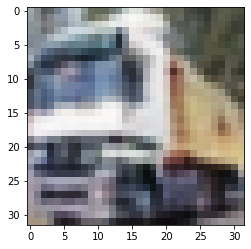

In [33]:
out=autoencoder_train.model.predict(x_test_final)
plt.imshow(out[0])
y_test_final[0]

In [34]:
outx_encoded_test=encoded.predict(x_test_final)
outx_encoded_train=encoded.predict(x_train)
outx_encoded_valid=encoded.predict(x_valid)
print(outx_encoded_test.shape,outx_encoded_train.shape,outx_encoded_valid.shape)


(16000, 8, 8, 128) (35200, 8, 8, 128) (8800, 8, 8, 128)


In [35]:
outx_encoded_test.shape[1]

8

Building CNN model for classification


In [0]:
# Model configuration

img_width, img_height, img_num_channels = outx_encoded_train.shape[1],outx_encoded_train.shape[2],outx_encoded_train.shape[3]
input_shape = (img_width, img_height, img_num_channels)
# loss_function = sparse_categorical_crossentropy
loss_function =categorical_crossentropy
no_classes = 10
no_epochs = 100
optimizer = Adam()
# validation_split = 0.2
verbosity = 1

In [0]:
# conv_model = Sequential([
#   Conv2D(32, 3,3, input_shape=(8, 8, 128)),
#   MaxPooling2D(pool_size=2),
#   Flatten(),
#   Dense(10, activation='softmax'),
# ])


In [0]:
from keras import datasets, layers, models
model = Sequential()
model.add(layers.Conv2D(1024, (3, 3), activation='relu', input_shape=(8, 8, 128),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))



conv_model=model

In [0]:
conv_model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

In [145]:
conv_model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 8, 8, 1024)        1180672   
_________________________________________________________________
batch_normalization_52 (Batc (None, 8, 8, 1024)        4096      
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 4, 4, 1024)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 4, 4, 128)         1179776   
_________________________________________________________________
batch_normalization_53 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 2, 2, 128)       

In [149]:

conv_history = conv_model.fit(outx_encoded_train, y_train,
            batch_size=512,
            epochs=no_epochs,
            verbose=verbosity,
            validation_data = (outx_encoded_valid, y_valid),shuffle=True,class_weight=class_weights)

Train on 35200 samples, validate on 8800 samples
Epoch 1/100
35200/35200 [==============================] - 6s 180us/step - loss: 0.0841 - acc: 0.9729 - val_loss: 1.3114 - val_acc: 0.7741
Epoch 2/100
35200/35200 [==============================] - 6s 180us/step - loss: 0.0939 - acc: 0.9700 - val_loss: 1.2738 - val_acc: 0.7764
Epoch 3/100
35200/35200 [==============================] - 6s 181us/step - loss: 0.0867 - acc: 0.9726 - val_loss: 1.3444 - val_acc: 0.7697
Epoch 4/100
35200/35200 [==============================] - 6s 180us/step - loss: 0.0851 - acc: 0.9726 - val_loss: 1.4215 - val_acc: 0.7616
Epoch 5/100
35200/35200 [==============================] - 6s 180us/step - loss: 0.0877 - acc: 0.9720 - val_loss: 1.3374 - val_acc: 0.7678
Epoch 6/100
35200/35200 [==============================] - 6s 182us/step - loss: 0.0884 - acc: 0.9725 - val_loss: 1.3446 - val_acc: 0.7695
Epoch 7/100
35200/35200 [==============================] - 6s 181us/step - loss: 0.0898 - acc: 0.9705 - val_loss: 1.2

In [151]:
score = conv_model.evaluate(outx_encoded_test, y_test_one_hot)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

16000/16000 [==============================] - 3s 166us/step
Test loss: 1.809190105766058 / Test accuracy: 0.7415625


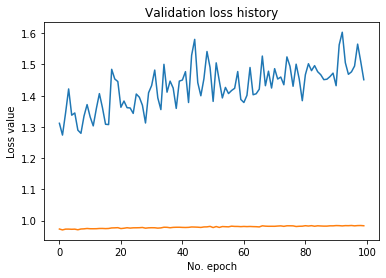

In [162]:
# Visualize history
# Plot history: Loss
plt.plot(conv_history.history['val_loss'])
plt.plot(conv_history.history['acc'])

plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

In [0]:
predictions = conv_model.predict(outx_encoded_test)

Classification Report:

              precision    recall  f1-score   support

    Airplane       0.62      0.83      0.71      1000
  Automobile       0.69      0.90      0.78      1000
        Bird       0.91      0.58      0.70      3000
         Cat       0.50      0.57      0.53      1000
        Deer       0.78      0.75      0.77      3000
         Dog       0.58      0.68      0.63      1000
        Frog       0.62      0.88      0.73      1000
       Horse       0.66      0.80      0.72      1000
        Ship       0.76      0.89      0.82      1000
       Truck       0.95      0.78      0.86      3000

    accuracy                           0.74     16000
   macro avg       0.71      0.77      0.72     16000
weighted avg       0.77      0.74      0.74     16000



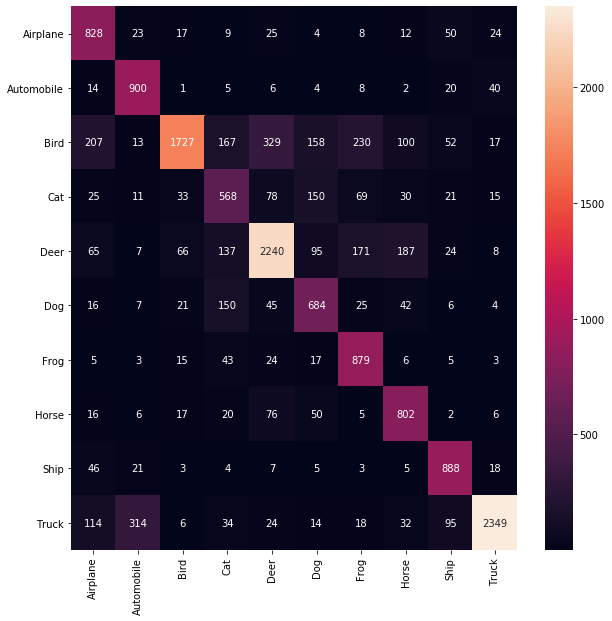

In [161]:
def report(predictions): ## function used for creating a classification report and confusion matrix
    cm=confusion_matrix(y_test_one_hot.argmax(axis=1), predictions.argmax(axis=1))
    print("Classification Report:\n")
    cr=classification_report(y_test_one_hot.argmax(axis=1),
                                predictions.argmax(axis=1), 
                                target_names=list(dict.values()))
    print(cr)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, xticklabels = list(dict.values()), yticklabels = list(dict.values()), fmt="d")
report(predictions)